## Estrutura para carregar um CSV diretamente da sua pasta no Google Drive, caso queira apenas ver o funcionamento do código, comece a partir da célula abaixo.

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

# Carrega o arquivo em csv em um DataFrame
# Apos ter sido executado o thsark e carregado o csv resultante no seu drive
# ajuste o caminho de acordo com suas pastas

df = pd.read_csv("/content/drive/My Drive/")

# Estrutura para visualizar o funcionamento do código, caso você já tenha o CSV carregado, NÃO EXECUTE ESTA CÉLULA.
Tratamento exclusivo para este csv apenas para demonstração.

Este csv foi extraído do conjunto de dados foi desenvolvido pela Universidade de New South Wales (UNSW) e consiste em rastreamentos de tráfego de rede coletados de diversos dispositivos IoT em um ambiente de teste controlado. Os dados foram utilizados no artigo "Classifying IoT Devices in Smart Environments Using Network Traffic Characteristics", publicado na revista IEEE Transactions on Mobile Computing em agosto de 2018.
Link para o dataset: https://iotanalytics.unsw.edu.au/iottraces.html

O dataset UNSW IoTTraces é utilizado principalmente para classificação de dispositivos IoT com base nas características do tráfego de rede gerado por cada equipamento, permitindo identificar automaticamente qual tipo de dispositivo está ativo em uma rede.

Para acelerar o processamento, foi utilizada apenas a captura do dia 28/09/2016.

In [139]:
import pandas as pd
import numpy as np

# Link de download direto
url = "https://www.dropbox.com/scl/fi/b8vfpp8gwzm3c60dz4qfr/saida_16-09-27.pcap.csv?rlkey=mq0636jda16ty8go5gx81d15s&st=wkn2948y&dl=1"
# Lê o CSV diretamente do Dropbox
df = pd.read_csv(url, on_bad_lines='skip')

df['src_port'] = df['tcp.srcport'].fillna(0).astype(int) + df['udp.srcport'].fillna(0).astype(int)
df['dst_port'] = df['tcp.dstport'].fillna(0).astype(int) + df['udp.dstport'].fillna(0).astype(int)

df = df.drop(columns=['tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport'])
df['eth.src'] = df['eth.src'].str.lower()
df.drop(df[(df['eth.dst'] == 'ff:ff:ff:ff:ff:ff') | (df['ip.dst'] == '255.255.255.255')].index, inplace=True)

mac_to_device_name = {
    '44:65:0d:56:cc:d3': 'Assistant1','00:24:e4:11:18:a8': 'BabyMonitor1','74:6a:89:00:2e:25': 'BlipcareBP1','70:ee:50:18:34:43': 'Camera1',
    'f4:f2:6d:93:51:f1': 'Camera2','00:16:6c:ab:6b:88': 'Camera3','30:8c:fb:2f:e4:b2': 'Camera4','d0:52:a8:00:67:5e': 'Device1','ec:1a:59:83:28:11': 'Motion1',
    'e0:76:d0:33:bb:85': 'Picturef1','70:5a:0f:e4:9b:c0': 'Printer1','00:24:e4:1b:6f:96': 'Scale1','18:b4:30:25:be:e4': 'Smoke1','50:c7:bf:00:56:39': 'Splug1',
    '18:b7:9e:02:20:44': 'Speaker1','08:21:ef:3b:fc:e3': 'Tablet1','70:ee:50:03:b8:ac': 'Weather1','ec:1a:59:79:f4:89': 'Wswitch1'
}

# add o rotulo do device por meio do mac
df['label'] = df['eth.src'].map(mac_to_device_name)
df = df.dropna(subset=['label'])

# Etapa seguindo o Fluxo de Trabalho para Captura, Processamento, Análise e Classificação de Tráfego de Rede

# 3. Pré-processamento dos Dados
### Objetivo
Limpar e transformar os dados para garantir que estejam prontos para análise estatística ou treinamento de modelos de machine learning.



In [140]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [141]:
#Visualizando as 5 primeiras linhas
print("Amostra dos dados:")
print(df.head())


Amostra dos dados:
   frame.time_epoch         ip.src         ip.dst            eth.src  \
0      1.474898e+09  192.168.1.106  52.87.241.159  30:8c:fb:2f:e4:b2   
2      1.474898e+09  192.168.1.106  52.87.241.159  30:8c:fb:2f:e4:b2   
3      1.474898e+09  192.168.1.106  52.87.241.159  30:8c:fb:2f:e4:b2   
6      1.474898e+09  192.168.1.106  52.87.241.159  30:8c:fb:2f:e4:b2   
9      1.474898e+09  192.168.1.240   23.23.189.20  44:65:0d:56:cc:d3   

             eth.dst  frame.len  ip.proto  src_port  dst_port       label  
0  14:cc:20:51:33:ea        156       6.0     40767       443     Camera4  
2  14:cc:20:51:33:ea        284       6.0     40767       443     Camera4  
3  14:cc:20:51:33:ea        156       6.0     40767       443     Camera4  
6  14:cc:20:51:33:ea        156       6.0     40767       443     Camera4  
9  14:cc:20:51:33:ea        201      17.0     49280     33434  Assistant1  


In [142]:
# salva em target_names os label antes de transformar em categoricos
target_names = df['label'].unique()
target_names

array(['Camera4', 'Assistant1', 'Device1', 'Camera1', 'BabyMonitor1',
       'Camera3', 'Camera2', 'Wswitch1', 'Speaker1', 'Printer1',
       'Motion1', 'Splug1', 'Tablet1', 'Picturef1', 'Weather1', 'Smoke1',
       'Scale1'], dtype=object)

In [143]:
# Remover colunas com muitos valores faltantes
df = df.dropna(thresh=len(df) * 0.5, axis=1)

# Preencher valores numéricos faltantes com a mediana
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Codificar variáveis categóricas
for col in df.select_dtypes(include=[object, "category"]).columns:
    df[col] = df[col].fillna("missing")
    df[col] = LabelEncoder().fit_transform(df[col])

# 4. Análise Exploratória dos Dados
### Objetivo
Explorar e entender a estrutura dos dados, identificar padrões e detectar potenciais problemas, como valores ausentes ou outliers.

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [145]:
print("\nResumo estatístico:")
print(df.describe())


Resumo estatístico:
       frame.time_epoch         ip.src         ip.dst        eth.src  \
count      2.338780e+05  233878.000000  233878.000000  233878.000000   
mean       1.474942e+09       6.204410     181.474961       5.812163   
std        2.358403e+04       6.654152      65.096378       4.160196   
min        1.474898e+09       0.000000       0.000000       0.000000   
25%        1.474923e+09       0.000000     143.000000       1.000000   
50%        1.474942e+09       4.000000     202.000000       6.000000   
75%        1.474960e+09      14.000000     202.000000       7.000000   
max        1.474985e+09      17.000000     295.000000      16.000000   

             eth.dst      frame.len       ip.proto       src_port  \
count  233878.000000  233878.000000  233878.000000  233878.000000   
mean        1.918073     191.867953       8.001398   39433.135703   
std         0.588362     220.984753       4.243803   13613.985259   
min         0.000000      43.000000       6.000000    

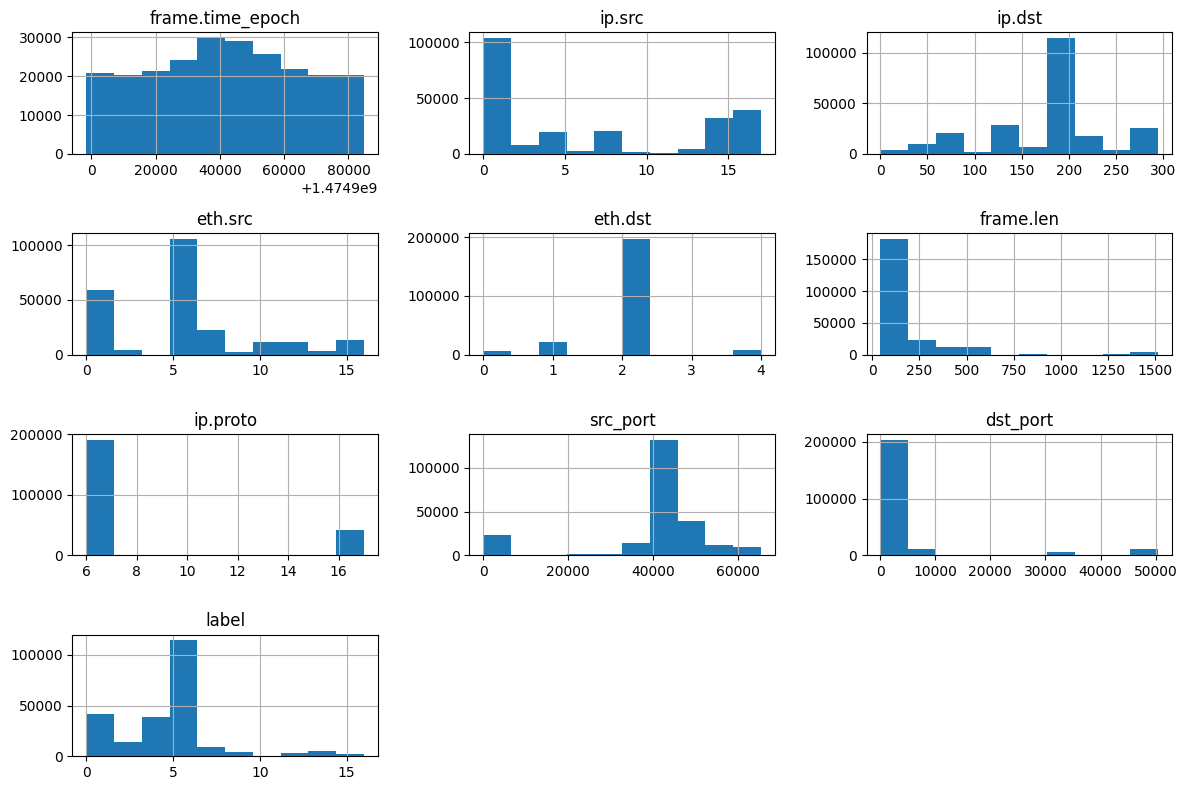

In [146]:
# Histograma de cada variável numérica
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# 5. Correlação de Características
## Objetivo
Identificar relações entre as variáveis do conjunto de dados, o que pode ajudar a selecionar as características mais importantes para a modelagem.

In [147]:
from sklearn.feature_selection import mutual_info_classif

correlation = df.corr()
print("Correlação de Pearson com a variável alvo:")
print(correlation['label'].sort_values(ascending=False))


Correlação de Pearson com a variável alvo:
label               1.000000
eth.src             0.203275
dst_port            0.070620
frame.time_epoch   -0.014108
frame.len          -0.054267
eth.dst            -0.095955
ip.proto           -0.219685
ip.dst             -0.249298
ip.src             -0.249964
src_port           -0.344418
Name: label, dtype: float64


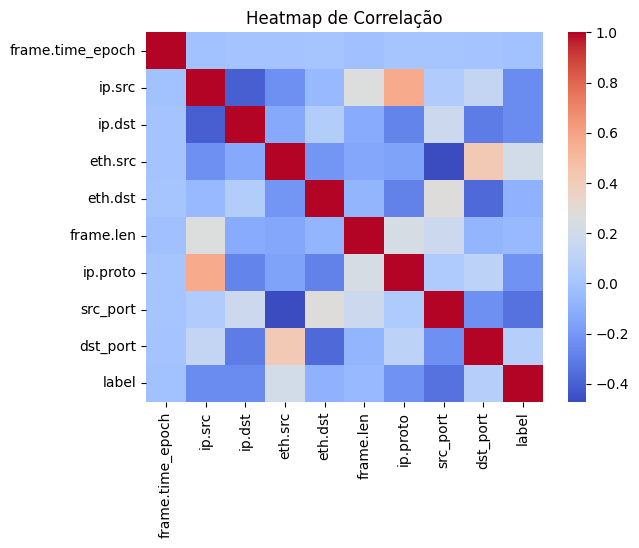

In [148]:
# Gráfico de correlação (para dar uma ideia de padrões)
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Heatmap de Correlação")
plt.show()

# 6. Seleção e Engenharia de Características
## Objetivo
Selecionar ou criar características mais representativas, melhorando o desempenho do modelo e reduzindo a complexidade computacional.

In [149]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [150]:
def feature_selection_engineering(df, target_column, method="selectkbest", k=5):
    X = df.drop(columns=['label'])
    y = df['label']

    if method == "selectkbest":
        selector = SelectKBest(score_func=f_classif, k=k)
        X_new = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()]
    elif method == "pca":
        pca = PCA(n_components=k)
        X_new = pca.fit_transform(X)
        selected_features = [f"PC{i+1}" for i in range(k)]
    elif method == "rfe":
        model = RandomForestClassifier()
        selector = RFE(model, n_features_to_select=k)
        selector = selector.fit(X, y)
        X_new = selector.transform(X)
        selected_features = X.columns[selector.get_support()]
    else:
        raise ValueError("Método de seleção desconhecido.")

    print(f"Características selecionadas ({method}): {selected_features}")
    return pd.DataFrame(X_new, columns=selected_features)

# 7. Modelagem
## Objetivo
Aplicar algoritmos de Machine Learning para resolver tarefas como classificação, regressão ou clusterização com base no tráfego de rede analisado.

In [151]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [152]:
# PARA USAR SELEÇÃO DE CARACTERÍSTICAS, EXECUTE APENAS ESTA CÉLULA.
# Caso não queira utilizar a seleção de características, execute apenas a célula abaixo.
# Escolha o método de seleção de características de acordo com seu problema: SelectKBest, PCA ou RFE.

X = feature_selection_engineering(df, target_column=df['label'], method="pca")
y = df['label']

Características selecionadas (pca): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


In [153]:
# Caso não vá fazer seleção de características, EXECUTE SOMENTE ESTA CÉLULA.
X = df.drop(columns=['label','ip.src','ip.dst','eth.src','eth.dst','ip.proto','src_port','dst_port'])
y = df['label']

In [154]:
# 2. Dividir em treino (70%), validação (15%) e teste (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42)
# 0.1765 ≈ 15% dos 85% -> para manter os 70/15/15

# 3. Treinar modelo Random Forest com base no treino
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 4. Avaliar no conjunto de validação
val_preds = rf.predict(X_val)
print("📋 Avaliação no conjunto de validação:")
print(classification_report(y_val, val_preds))

# 5. Avaliar no conjunto de teste final
test_preds = rf.predict(X_test)
print("📋 Avaliação no conjunto de teste:")
print(classification_report(y_test, test_preds))

📋 Avaliação no conjunto de validação:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3360
           1       0.43      0.87      0.58      2961
           2       0.92      0.87      0.89      1459
           3       0.79      0.63      0.70       700
           4       0.86      0.75      0.80      5875
           5       0.99      0.97      0.98     15342
           6       1.00      0.99      0.99      1791
           7       0.68      0.32      0.43      1352
           8       0.81      0.42      0.55       395
           9       0.98      0.93      0.96       183
          10       0.83      0.68      0.75        22
          11       0.87      0.93      0.90        14
          12       0.97      0.25      0.39       500
          13       0.44      0.26      0.33       165
          14       0.72      0.70      0.71       640
          15       0.65      0.51      0.57       213
          16       0.05      0.03      0.04

# 8. Avaliação de Modelos
## Objetivo
Medir o desempenho dos modelos em dados não vistos e garantir sua capacidade de generalização para novos dados.

In [155]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

✅ Acurácia: 0.8420
✅ Precisão: 0.7623
✅ Revocação (Recall): 0.6462
✅ F1-Score: 0.6748

📊 Relatório detalhado por classe:
              precision    recall  f1-score   support

     Camera4       0.83      0.78      0.80      3360
  Assistant1       0.43      0.86      0.58      2960
     Device1       0.92      0.86      0.89      1459
     Camera1       0.76      0.63      0.69       700
BabyMonitor1       0.86      0.76      0.81      5874
     Camera3       0.99      0.97      0.98     15340
     Camera2       0.99      0.99      0.99      1791
    Wswitch1       0.66      0.31      0.42      1352
    Speaker1       0.83      0.42      0.56       395
    Printer1       0.98      0.94      0.96       183
     Motion1       0.88      0.68      0.77        22
      Splug1       0.82      1.00      0.90        14
     Tablet1       0.95      0.26      0.41       499
   Picturef1       0.50      0.24      0.32       165
    Weather1       0.77      0.73      0.75       639
      Smoke1  

<ipython-input-156-e0ebbfc7853e>:29: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


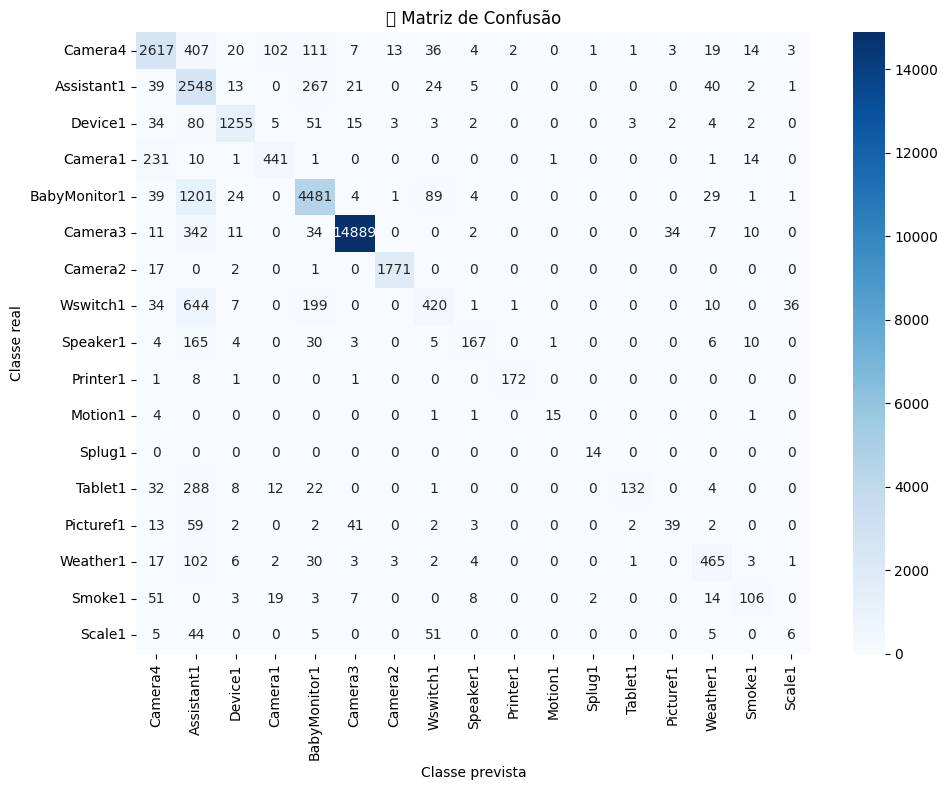

In [156]:
# 1. Acurácia
accuracy = accuracy_score(y_test, test_preds)
print(f"✅ Acurácia: {accuracy:.4f}")

# 2. Precisão
precision = precision_score(y_test, test_preds, average='macro')
print(f"✅ Precisão: {precision:.4f}")

# 3. Revocação (Recall)
recall = recall_score(y_test, test_preds, average='macro')
print(f"✅ Revocação (Recall): {recall:.4f}")

# 4. F1-Score
f1 = f1_score(y_test, test_preds, average='macro')
print(f"✅ F1-Score: {f1:.4f}")

df['label'].unique()
# 5. Relatório completo
print("\n📊 Relatório detalhado por classe:")
print(classification_report(y_test, test_preds, target_names=target_names))

# 6. Matriz de Confusão
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("📌 Matriz de Confusão")
plt.ylabel("Classe real")
plt.xlabel("Classe prevista")
plt.tight_layout()
plt.show()

<ipython-input-157-6fcf319232e8>:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


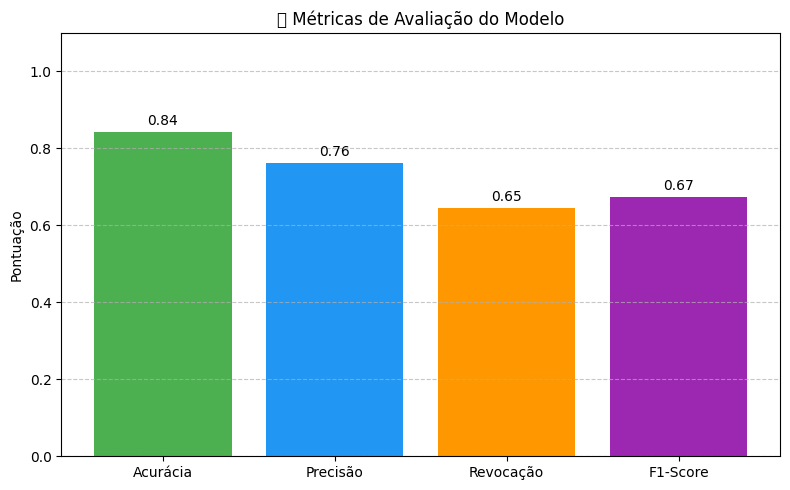

In [157]:
# Suponha que já temos essas métricas calculadas:
metrics = {
    "Acurácia": accuracy,
    "Precisão": precision,
    "Revocação": recall,
    "F1-Score": f1
}

# Dados para o gráfico
labels = list(metrics.keys())
values = list(metrics.values())

# Gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color=['#4caf50', '#2196f3', '#ff9800', '#9c27b0'])

# Adiciona os valores no topo das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.title('📊 Métricas de Avaliação do Modelo')
plt.ylabel('Pontuação')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()